In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Project Title
### Data Engineering Capstone Project



### Step 1: Scope the Project and Gather Data


#### Goal
Transform Amazon bestsellers and reviews data to predict how reviews determine a sellers store performance

#### Scope
We only focus on amazon bestsellers data (top sellers on the site) and their reviews.

### Data
Amazon Bestsellers [data]
)

Amazon Reviews [data](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

In [2]:
%pip install pyspark

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.types import *
import pyspark.sql.functions as F

import configparser
import os

In [4]:
#create spark sesson
import pyspark
def create_spark_session():

    """
    Description:
      Creates spark session based on the spark and hadoop package of interest
    Returns:
      spark session
    """
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.3,org.postgresql:postgresql:42.2.6") \
        .getOrCreate()
    return spark
#create the spark session
spark = create_spark_session()

### Set AWS credentials 

In [5]:
config = configparser.ConfigParser()
aws_local_creds_dir = "/content/drive/MyDrive/udacity_capstone/aws_local_creds.cfg"
config.read_file(open(aws_local_creds_dir))
#the access key and secret access key that's generated when your create an IAM user
#note that the new user should have the "AmazonS3FullAccess" policy to access your s3 bucket
#no longer used because of data transfer costs
"""
os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']
"""

In [6]:
#no longer used because of data transfer costs
"""
AWS_ACCESS_KEY_ID = os.environ["AWS_ACCESS_KEY_ID"]
AWS_SECRET_ACCESS_KEY = os.environ["AWS_SECRET_ACCESS_KEY"]
"""

In [7]:
#connect spark to s3
#no longer used because of data transfer costs
"""
hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3n.impl", "org.apache.hadoop.fs.s3native.NativeS3FileSystem")
hadoop_conf.set("fs.s3n.awsAccessKeyId",AWS_ACCESS_KEY_ID)
hadoop_conf.set("fs.s3n.awsSecretAccessKey", AWS_SECRET_ACCESS_KEY)
hadoop_conf.set("fs.s3n.endpoint", "s3.amazonaws.com")
"""

### Step 2: Explore and Assess the Data

#### get data from s3


get bestseller data


In [8]:
"""
#no longer using AWS because of data transfer transaction costs
#using google drive instead
"""
# Read in the data here
#amazon best sellers data
#input_path = "s3n://amazon-udacity/amazon-bestseller/amazon_bestsellers.csv"
#Google Drive
input_path = "/content/drive/MyDrive/udacity_capstone/amazon_bestsellers.csv"
bestseller_df = spark.read.option("header", "true").csv(input_path)

Basic analysis of our  bestseller data

In [9]:
bestseller_df.printSchema()

root
 |-- ASIN: string (nullable = true)
 |-- category: string (nullable = true)
 |-- links: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: string (nullable = true)
 |-- image url: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- No of reviews: string (nullable = true)



In [10]:
bestseller_df.count()

6758084

In [11]:
bestseller_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------------+
|                ASIN|            category|               links|               title|               price|           image url|rating|No of reviews|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------------+
|          B07HF3X6Y4|Any Department/Ho...|https://www.amazo...|                   "|                null|                null|  null|         null|
|            Hilif...| Handheld Garment...| Mini Travel Stea...|                null|                null|                null|  null|         null|
|                   "|              $24.99|https://images-na...|  4.4 out of 5 stars|              15,233|                null|  null|         null|
|          B07JVFZJT7|Any Department/Ho...|https://www.amazo...|                   "|                null|

get reviews data

In [12]:
"""
#no longer using AWS because of data transfer transaction costs
#using google drive instead
"""
#amazon reviews data
#reviews_path = "s3n://amazon-udacity/amazon-reviews/amazon_reviews.csv"
#google Drive
reviews_path = "/content/drive/MyDrive/udacity_capstone/amazon_reviews.csv"
reviews_df = spark.read.option("header", "true").csv(reviews_path)

Basic analysis of our  reviews |data

In [13]:
reviews_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [14]:
reviews_df.count()

568454

In [15]:
reviews_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [16]:
reviews_df.show()

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

Get some descriptive analytics of the bestsellers and reviews tables before joining them

In [17]:
bestseller_df.describe().show()

+-------+--------------------+---------------------+----------------------+--------------------+----------------------+--------------------+--------------------+--------------------+
|summary|                ASIN|             category|                 links|               title|                 price|           image url|              rating|       No of reviews|
+-------+--------------------+---------------------+----------------------+--------------------+----------------------+--------------------+--------------------+--------------------+
|  count|             6758083|              5537046|               5144424|             4882408|               2484459|              139417|               82076|               46463|
|   mean| 1.857587926621902E9| 2.6034076212584668E8|              Infinity| 3.024202732486609E9|    1150983.3823096473| 9.485048104273513E7| 8.636156510897866E7|6.6699477352379285E7|
| stddev| 2.256854907329768E9|   7.90857523731988E9|                   NaN|1.12243720

In [18]:
reviews_df.describe().show()

+-------+------------------+-------------------+------------------+-----------+--------------------+----------------------+-----------------+--------------------+--------------------+--------------------+
|summary|                Id|          ProductId|            UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|            Score|                Time|             Summary|                Text|
+-------+------------------+-------------------+------------------+-----------+--------------------+----------------------+-----------------+--------------------+--------------------+--------------------+
|  count|            568454|             568454|            568454|     568454|              568452|                568452|           568451|              568449|              568448|              568444|
|   mean|          284227.5|6.588314217660668E9|              null|        NaN|  1.7404362359754146|    2.2252822569278043|4.176305349530591|1.2900618961141965E9|                 N

Rename and columns to perform queries

In [19]:
# add an unique id column to bestsellers
bestsellers_df = bestseller_df.withColumn("bestseller_id", F.monotonically_increasing_id())
bestsellers_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------------+-------------+
|                ASIN|            category|               links|               title|               price|           image url|rating|No of reviews|bestseller_id|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------------+-------------+
|          B07HF3X6Y4|Any Department/Ho...|https://www.amazo...|                   "|                null|                null|  null|         null|            0|
|            Hilif...| Handheld Garment...| Mini Travel Stea...|                null|                null|                null|  null|         null|            1|
|                   "|              $24.99|https://images-na...|  4.4 out of 5 stars|              15,233|                null|  null|         null|            2|
|          B07JVFZJT7|

In [20]:
#rename  columns in best_seller
bestsellers_df = bestsellers_df.withColumnRenamed("image url","image_url")\
                .withColumnRenamed("No of reviews","no_of_reviews")\
                .withColumnRenamed("ASIN", "bestseller_description")

In [21]:
#rename no of reviews
bestsellers_df.printSchema()

root
 |-- bestseller_description: string (nullable = true)
 |-- category: string (nullable = true)
 |-- links: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- no_of_reviews: string (nullable = true)
 |-- bestseller_id: long (nullable = false)



In [22]:
# rename columns in reviews
reviews_df = reviews_df.withColumnRenamed("Id", "review_id")\
                       .withColumnRenamed("ProductId", "product_id")\
                       .withColumnRenamed("UserId", "user_id")\
                       .withColumnRenamed("ProfileName", "profile_name")\
                       .withColumnRenamed("HelpfulnessNumerator", "helpfulness_numerator")\
                       .withColumnRenamed("HelpfulnessDenominator", "helpfulness_denominator")

In [23]:
reviews_df.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- profile_name: string (nullable = true)
 |-- helpfulness_numerator: string (nullable = true)
 |-- helpfulness_denominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



#Null values
check the number of null values the bestsellers and reviews

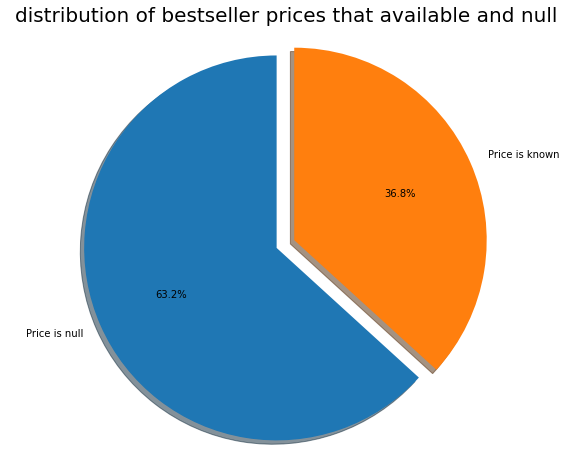

In [24]:
#Examine the distribution of prices that are null and available
price_null = bestsellers_df.filter("price IS NULL").count()
price_available = bestsellers_df.filter("price IS NOT NULL").count()

labels = 'Price is null', 'Price is known'
size= [price_null, 
       price_available]
explode = (0, 0.1)
fig1, ax1  = plt.subplots(figsize=(10,8))
ax1.pie(size, explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("distribution of bestseller prices that available and null", size =20)
plt.show()

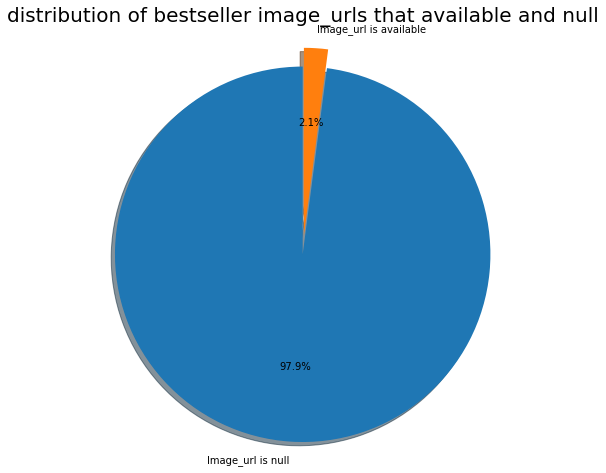

In [25]:
# Examine the distribution of image_urls that are null and available
image_url_null = bestsellers_df.filter("image_url is NUll").count()
image_url_available = bestsellers_df.filter("image_url IS NOT NUll").count()

labels = 'Image_url is null', 'Image_url is available'
size= [image_url_null, 
       image_url_available]
explode = (0, 0.1)
fig1, ax1  = plt.subplots(figsize=(10,8))
ax1.pie(size, explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("distribution of bestseller image_urls that available and null", size =20)
plt.show()

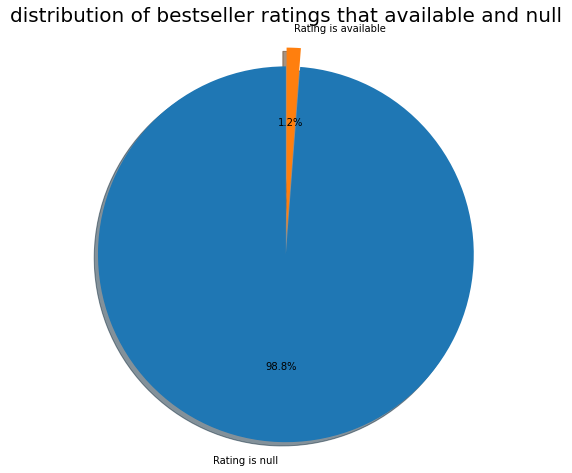

In [26]:
# Examine the distribution of rating that are null and available
rating_null = bestsellers_df.filter("rating is NULL").count()
rating_available = bestsellers_df.filter("rating IS NOT NULL").count()

labels = 'Rating is null', 'Rating is available'
size= [rating_null, 
       rating_available]
explode = (0, 0.1)
fig1, ax1  = plt.subplots(figsize=(10,8))
ax1.pie(size, explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("distribution of bestseller ratings that available and null", size =20)
plt.show()

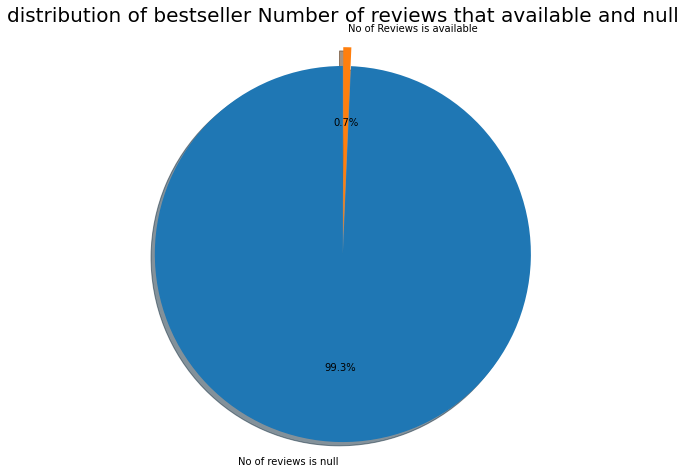

In [27]:
# Examine the distribution of no_of_reviews that are null and available
no_of_reviews_null = bestsellers_df.filter("no_of_reviews is NUll").count()
no_of_reviews_available = bestsellers_df.filter("no_of_reviews IS NOT NUll").count()

labels = 'No of reviews is null', 'No of Reviews is available'
size=  [no_of_reviews_null, 
       no_of_reviews_available]
explode = (0, 0.1)
fig1, ax1  = plt.subplots(figsize=(10,8))
ax1.pie(size, explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("distribution of bestseller Number of reviews that available and null", size =20)
plt.show()

## Replace null values
* Despite the primary interest is to matching bestsellers to reviews
* Null no_of_review rows make up % of our dataset
* therefore, we wil just replace "NaN" with nul values

In [28]:
def replace_null(df):
  """
  Description:
    Replaces null values in spark dataframes with the "None" keyword
  Args
    df - our target dataframe
  Returns:
    None
  """
  df = df.replace(float('nan'), None)
  return None

In [29]:
replace_null(bestsellers_df)

In [30]:
replace_null(reviews_df)

### Remove duplicates
We want data on distinct bestsellers and reviews, Therefore:
* we will remove duplicates in the columns bestseller_id in the bestseller table  
* And remove duplicates in the reviews_id column in reviews table

In [31]:
def remove_duplicates(df, df_id):
  """
  Description 
    - removes duplicate vaues in spark dataframes
  Args:
    - df: our target dataframe
    - df_id: the primary key/index of our dataframe
  Returns
  - None
  """
  df = df.dropDuplicates([df_id])
  
  return None

In [32]:
bestseller_id = "bestseller_id"
remove_duplicates(bestsellers_df, bestseller_id)

In [33]:
reviews_id = "review_id"
remove_duplicates(reviews_df, reviews_id)

check any changes in our tables count

In [34]:
bestsellers_df.count()

6758084

In [35]:
reviews_df.count()

568454

### Convert the timestamp
* In the reviews_table, we need to to convert the time column into a timestamp
segemented by day, week, month and year.
* In essence, creating a new table time that will be utilized in our schema

In [36]:
#drop null values in the time column of the reviews_df
#reviews_df.filter("time is Null").count()
reviews_df=reviews_df.filter("time is NOT NULL AND time != 'NaN' ")
#reviews_df.count()

#### pandas datetime conversion
* convert your spark dataframe to a pandas dataframe
* convert it to integer values
* then convert to a datatime

#### spark datetime conversion
* convert your pandas dataframe to a spark dataframe
* convert it to integer values
* then convert to a datatime

#### result
we have our target datatype from which we can create our reviews_time table:
* we then split the column into year, month and data columns


In [37]:
reviews_time = reviews_df.select("time")
#reviews_time.show(5, False) 

In [38]:
from pyspark.sql.types import IntegerType
from datetime import datetime

In [39]:
def datetime_conversion(timestamp_col):
  """
  Description:
    - convert its time column from string to an integer
    - convert spark dataframe to a pandas dataframe
    - convert this time column to a datatime datatype
  Args:
    - timestamp_col: the column containing our timestamp
  Returns
    - our datatime datatype
  """
  df = globals()["reviews_time"]
  print(f"time column datatype: {df.dtypes}")
  # Convert the string time to an integer
  df = df.withColumn("time", df[timestamp_col].cast(IntegerType()))
  print(f"time column datatype: {df.dtypes}")
  #convert the reviews_time to a pandas dataframe
  df = df.toPandas()
  #drop null values
  df = df.dropna()
  #check for any null values
  print(f"Null values in dataframe: {df.isnull().sum()}")
  #convert to datetime
  df[timestamp_col] = [datetime.fromtimestamp(x) for x in df[timestamp_col]]
  print(f"pandas df datatype: {df.dtypes}")
  # convert it back to a spark dataframe
  df = spark.createDataFrame(df)
  # now convert into a spark timestamp with the to_date function
  df =  df.withColumn(timestamp_col,F.to_date(F.col(timestamp_col),'yyyyMMdd'))
  #return the new column with a datatime datatype
  print(f"spark datatype: {df.dtypes}")
  #assert the our reviews_time is our local dataframe
  globals()["reviews_time"] = df
  #return our target dataframe
  return df.show(5, False)



In [40]:
timestamp_col = "time"

datetime_conversion(timestamp_col)


time column datatype: [('time', 'string')]
time column datatype: [('time', 'int')]
Null values in dataframe: time    0
dtype: int64
pandas df datatype: time    datetime64[ns]
dtype: object
spark datatype: [('time', 'date')]
+----------+
|time      |
+----------+
|2011-04-27|
|2012-09-07|
|2008-08-18|
|2011-06-13|
|2012-10-21|
+----------+
only showing top 5 rows



Creating the final reviews time column
* we will split our reviews_time to three columns: year, month and day
* add a primarykey/index called time_id
* then rename the time column to datetime

In [41]:
#Split the reviews_time table to year, month, week columns
reviews_time = reviews_time.withColumn('year',F.year(reviews_time.time))\
                   .withColumn("month", F.month(reviews_time.time))\
                   .withColumn("day", F.dayofmonth(reviews_time.time))
#reviews_time.show()
#create time id 
reviews_time = reviews_time.withColumn("time_id", F.monotonically_increasing_id())
#rename the review column
reviews_time = reviews_time.withColumnRenamed('time','datetime')
#print the final column
reviews_time.show(5, False)

+----------+----+-----+---+-------+
|datetime  |year|month|day|time_id|
+----------+----+-----+---+-------+
|2011-04-27|2011|4    |27 |0      |
|2012-09-07|2012|9    |7  |1      |
|2008-08-18|2008|8    |18 |2      |
|2011-06-13|2011|6    |13 |3      |
|2012-10-21|2012|10   |21 |4      |
+----------+----+-----+---+-------+
only showing top 5 rows



In [42]:
reviews_time.count()

568441

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Star schema
I chose to utilize the star schema because:
* we can easily separate factual data such as price, score from descriptive data with features such as name, category etc
* we can easily perform joins between fact tables and dimensional tables because the fact table contains foreign keys referencing our fact tables
* the tables are denormalised to speed up sql queries and reads
* [source](https://www.integrate.io/blog/snowflake-schemas-vs-star-schemas-what-are-they-and-how-are-they-different/)



### Mapping Out Data Pipelines
#### Upload Google drive
* download kaggle datasets from links provided above
* Note that due to data transfer charges, we have uploaded to google drive 
instead of s3
* go to your google drive and upload the data
#### use google colab  to connect to google drive
* create your spark session
* Note that because of data transfer charges, we have connected to google drive instead to access the data
* mount your google drive to your google colab notebook
#### Preprocess and clean data
* Clean the best seller and reviews table by:
  * removing duplicates(for their respective table ids)
  * replacing null values with NaN,
* create a time table
   * extract the timestamp from the reviews table as a reviews_time table
   * convert it's string values into integers
   * convert to a pandas data frame then change it to a datetime datatype
   * convert back to a spark dataframe and segement into year, month and day columns
* drop the time column from the reviews table

#### Create the Star schema
* create the dimension tables bestseller, reviews, time
* fact table bestseller_reviews

#### Run data Quality checks
* check if the fact and dimensions tables have no records

#### Run analysis queries
* WE will use joins between our fact and dimension tables to complete queries
### Upload to google drive
* convert data to parquet to reduce the size
* We will save our data to google drive

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

old denormalized schema

In [43]:
bestsellers_df.printSchema()
reviews_df.printSchema()
reviews_time.printSchema()

root
 |-- bestseller_description: string (nullable = true)
 |-- category: string (nullable = true)
 |-- links: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- no_of_reviews: string (nullable = true)
 |-- bestseller_id: long (nullable = false)

root
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- profile_name: string (nullable = true)
 |-- helpfulness_numerator: string (nullable = true)
 |-- helpfulness_denominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)

root
 |-- datetime: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- time_id: long (nullable = false)



## Dimension Tables
### bestseller
* bestseller_id,
* bestseller_description
* category,
* links,
* title,
* image_url,
* rating

### reviews
* review_id, 
* profile_name,
* summary
* text

### time
* time,
* day
* month
* year

In [44]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, IntegerType, DateType

bestsellers

In [45]:
#initialize our values
bestseller_cols = ["bestseller_id","bestseller_description", "category", "links", "title", "image_url", "rating"]
bestsellers_schema = StructType([
    StructField("bestseller_id", LongType(), False),
    StructField("bestseller_description", StringType(), True),
    StructField("category", StringType(), True),
    StructField("links", StringType(), True),
    StructField("title", StringType(), True),
    StructField("image_url", StringType(), True),
    StructField("rating", StringType(), True)
])

bestsellers = spark.createDataFrame([], bestsellers_schema)

In [46]:
"""
- note that we are getting our updating our global initial dimension table for 
  each function
- this is because without updating the global_variable, the table insertion will 
  remain a local variable in the function.
- In turn, this means will fail to insert data from our dataframes into 
  the new sql table
"""

def create_dim_bestsellers_table(table, df, cols):
  """
  description
    - this function will create our dimension tables
  Args:
    - table: our target table
    - df: the dataframe utilized to create our table
    - cols: the new columns created for our table
  Returns:
    - the target table's schema
  """
  #set our table as the global table
  #note
  table = df.select(
      cols
  )
  ### update our global bestseller table with the inserted data
  globals()["bestsellers"] = table
  #return the schema of our new table

  return table.printSchema()

In [47]:
create_dim_bestsellers_table(bestsellers, bestsellers_df, bestseller_cols)

root
 |-- bestseller_id: long (nullable = false)
 |-- bestseller_description: string (nullable = true)
 |-- category: string (nullable = true)
 |-- links: string (nullable = true)
 |-- title: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- rating: string (nullable = true)



In [48]:
bestsellers.show(5, False)

+-------------+-----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------+-------------------------------------------------------------------------------------------------------------------+------------------+---------+------+
|bestseller_id|bestseller_description                                                                                                       |category                                       |links                                                                                                              |title             |image_url|rating|
+-------------+-----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------+-------------------------------------------------------------------------------------------------------------------+-----------

reviews

In [49]:
#initialize our values
review_cols = ["review_id","profile_name", "Summary", "Text"]
# create reviews table
reviews_schema = StructType([
    StructField("review_id", LongType(), False),
    StructField("profile_name", StringType(), True),
    StructField("Summary", StringType(), True),
    StructField("Text", StringType(), True)
])

reviews = spark.createDataFrame([], reviews_schema)

In [50]:
"""
- note that we are getting our updating our global initial dimension table for 
  each function
- this is because without updating the global_variable, the table insertion will 
  remain a local variable in the function.
- In turn, this means will fail to insert data from our dataframes into 
  the new sql table
"""
#create the reviews table
def create_dim_reviews_table(table, df, cols):
  """
  description
    - this function will create our dimension tables
  Args:
    - table: our target table
    - df: the dataframe utilized to create our table
    - cols: the new columns created for our table
  Returns:
    - the target table's schema
  """
  #insert data in table
  table = df.select(
      cols
  )
  # update our global time table with the inserted data
  globals()["reviews"] = table
  #return the schema of our new table

  return table.printSchema()

In [51]:
create_dim_reviews_table(reviews, reviews_df, review_cols)

root
 |-- review_id: string (nullable = true)
 |-- profile_name: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [52]:
reviews.show(5, False)

+---------+-----------------------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id|profile_name                       |Summary                  |Text                                                                                                                                                                                                                                                                                                                                                                                              |
+---------+-----------------------------------+-------------------------+-----

time

In [90]:
time_cols = ["time_id", "datetime", "day", "month", "year"]

time_schema = StructType([
    StructField("time_id", LongType(), False),
    StructField("datetime", DateType(), True),
    StructField("day", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("year", IntegerType(), True),
])

time = spark.createDataFrame([], time_schema)

In [91]:
"""
- note that we are getting our updating our global initial dimension table for 
  each function
- this is because without updating the global_variable, the table insertion will 
  remain a local variable in the function.
- In turn, this means will fail to insert data from our dataframes into 
  the new sql table
"""
def create_dim_time_table(table, df, cols):
  """
  description
    - this function will create our dimension tables
  Args:
    - table: our target table
    - df: the dataframe utilized to create our table
    - cols: the new columns created for our table
  Returns:
    - the target table's schema
  """
  #insert data into table
  table = df.select(
      cols
  )
  ### update our global time table with the inserted data
  globals()["time"] = table
  #return the schema of our new table

  return table.printSchema()

In [92]:
create_dim_time_table(time, reviews_time, time_cols)

root
 |-- time_id: long (nullable = false)
 |-- datetime: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [93]:
#time dimension table
time.show(5, False)

+-------+----------+---+-----+----+
|time_id|datetime  |day|month|year|
+-------+----------+---+-----+----+
|0      |2011-04-27|27 |4    |2011|
|1      |2012-09-07|7  |9    |2012|
|2      |2008-08-18|18 |8    |2008|
|3      |2011-06-13|13 |6    |2011|
|4      |2012-10-21|21 |10   |2012|
+-------+----------+---+-----+----+
only showing top 5 rows



## Fact table
### bestseller_reviews
* bestseller_id
* price
* no_of_reviews
* review_id
* product_id
* user_id
* helpfulness_numerator
* helpfulness_denominator
* score
* time_id
* bestseller_review_id

* we will convert our old dataframes to pandas
* join them to one fact table
* then create a fact table as pandas dataframe

In [57]:
#initalization of tables of interest
bestsellers_fact = bestsellers_df.select(["bestseller_id", "price", "no_of_reviews"])
reviews_fact = reviews_df.select(["review_id", "product_id", "user_id","helpfulness_numerator","helpfulness_denominator", "Score"])
time_fact = reviews_time.select(["time_id"])
df_list = [bestsellers_fact, reviews_fact, time_fact]
fact_schema = StructType([
    StructField("bestseller_id", LongType(), False),
    StructField("price", IntegerType(), True),
    StructField("no_of_reviews", StringType(), True),
    StructField("review_id", LongType(), False),
    StructField("product_id", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("helpfulness_numerator", StringType(), True),
    StructField("helpfulness_denominator", StringType(), True),
    StructField("score", StringType(), True),
    StructField("time_id", LongType(), False)
])
bestsellers_reviews = spark.createDataFrame([], fact_schema)
bestsellers_reviews = bestsellers_reviews.toPandas()

In [58]:
#empty fact table
bestsellers_reviews.head(5)

,bestseller_id,price,no_of_reviews,review_id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time_id


In [59]:
#create fact table function
def create_bestsellers_reviews_fact_table(df_list, id_col):
  """
    Description:
      - This function creates our fact table
    Args:
      - df_list: the list of tables we will concat to create the fact table in pandas
      - id_col: the col that will act as the index of our fact_table
    Returns:
      - joined fact_table first 5 values
  """
  #convert the spark dataframes to pandas
  fact_pd1 = df_list[0].toPandas()
  fact_pd2 = df_list[1].toPandas()
  fact_pd3 = df_list[2].toPandas()
  #concatenate the tables
  fact_temp = pd.concat([fact_pd1, fact_pd2])
  fact_temp = pd.concat([fact_temp, fact_pd3])
  #update id
  fact_temp.insert(0, id_col, range(1, 1 + len(fact_temp)))
  ### update our global bestsellers table with the fact table
  globals()["bestsellers_reviews"] = fact_temp
  #return the first 5 rows of the updated bestsellers_table table
  return fact_temp.head(5)

In [60]:
id_col = "bestsellers_reviews_id"
create_bestsellers_reviews_fact_table(df_list, id_col)

,bestsellers_reviews_id,bestseller_id,price,no_of_reviews,review_id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,Score,time_id
0,1,0.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.0,"15,233",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#check if bestsellers_reviews table has been updated with data from our denormalised tables
bestsellers_reviews.head(5)

,bestsellers_reviews_id,bestseller_id,price,no_of_reviews,review_id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,Score,time_id
0,1,0.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.0,"15,233",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

Data quality check 1(a) and 1(b)

In [62]:
# Check null values
def no_records_dim_quality_check(dim_df, name):
    '''
    Description:
      This function checks if any of our dimension tables are null before uploading them to the target data source
    Argss:
      - dim_df: our dataframe
      - name: the name of the table going through the quailty check
    Returns:
      - Check if the table is empty or has values    
    '''
    result = dim_df.count()
    if result == 0:
        print("Data quality check failed for {} with zero records".format(name))
    else:
        print("Data quality check passed for {} with {} records".format(name, result))



check the dimensions tables

In [63]:
no_records_dim_quality_check(bestsellers, "bestsellers table")

Data quality check passed for bestsellers table with 6758084 records


In [64]:
no_records_dim_quality_check(reviews, "reviews table")

Data quality check passed for reviews table with 568449 records


In [65]:
no_records_dim_quality_check(time, "time table")

Data quality check passed for time table with 568441 records


In [66]:
# Check null values
def no_records_fact_quality_check(fact_df, name):
    '''
    Description:
      This function checks if any of our fact tables are null before uploading them to the target data source
    Argss:
      - fact_df: our dataframe
      - name: the name of the table going through the quailty check
    Returns:
      - Check if the table is empty or has values    
    '''
    result = fact_df.shape[0]
    if result == 0:
        print("Data quality check failed for {} with zero records".format(name))
    else:
        print("Data quality check passed for {} with {} records".format(name, result))



In [67]:
no_records_fact_quality_check(bestsellers_reviews, "bestsellers_reviews")

Data quality check passed for bestsellers_reviews with 7894974 records


check the fact table



Data Quality Check 2

In [68]:
#check if the time column has been parsed to a datetime column
def check_datetime(original_time_col, new_time_col):
  """
  Description:
    this function checks of the time column has been parsed to a datetime datatype
  Args:
    - original_df: the original reviews time column 
    - new_df: the new parsed reviews time column
  Returns:
    - a dataframe that compares the old  reviews time column to the new reviews time column
  """
  new_df = pd.concat([original_time_col, new_time_col])
  #the data types of the old time column
  print(f"Old reviews time column datatypes: {original_time_col.nunique()}")
  #the data types of the new time column
  print(f"New reviews time column datatypes: {new_time_col.nunique()}")
  #return the comparsion of the old and new datetime column
  return new_df.tail(10)

In [69]:
old_col = reviews_df.select("time").toPandas()
new_col = time.select("datetime").toPandas()

In [70]:
check_datetime(old_col, new_col)

Old reviews time column datatypes: time    3204
dtype: int64
New reviews time column datatypes: datetime    3168
dtype: int64


,time,datetime
568431,NaN,2009-06-19
568432,NaN,2010-03-08
568433,NaN,2012-02-11
568434,NaN,2011-11-29
568435,NaN,2011-06-15
568436,NaN,2011-03-09
568437,NaN,2012-03-09
568438,NaN,2012-02-21
568439,NaN,2012-03-13
568440,NaN,2012-05-31


Data Quality Check 3(a) and 3(b)



* Check if our dimension tables are spark dataframes
* Check if our fact table is a pandas dataframe

In [71]:
from pyspark.sql import DataFrame

In [72]:
def is_sparkDF(df):
  """
  Description
    - this function checks if our fact and dimension tables are spark dataframes
    - this needs to be run before saving to the target data destination
  Args:
    - table: the target table
  Returns:
    - Confirmation of whether the target table is a spark dataframe or not
  """
  confirm_df = isinstance(df, DataFrame)
  if confirm_df == True:
    print("The Table is a spark Dataframe")
  else:
    print("The Table is not a spark Dataframe")

In [73]:
is_sparkDF(bestsellers)

The Table is a spark Dataframe


In [74]:
is_sparkDF(reviews)

The Table is a spark Dataframe


In [75]:
is_sparkDF(time)

The Table is a spark Dataframe


In [76]:
def is_pandasDF(df):
  """
  Description
    - this function checks if our fact and dimension tables are  pandas D dataframes
    - this needs to be run before saving it to the target destination
  Args:
    - table: the target table
  Returns:
    - Confirmation of whether the target table is a spark dataframe or not
  """
  confirm_df = isinstance(df, pd.DataFrame)
  if confirm_df == True:
    print("The Table is a pandas Dataframe")
  else:
    print("The Table is not a pandas Dataframe")

In [77]:
is_pandasDF(bestsellers_reviews)

The Table is a pandas Dataframe


### Performing analytical queries:
#### Query 1
What are the number of reviews for each category

In [78]:
dim_cols = ["bestseller_id", "category"]
fact_cols = ["bestseller_id", "no_of_reviews"]
target_id = "bestseller_id"
#initialize an empty dataframe
query = pd.DataFrame()

In [79]:
def merge_query_tables(dim_cols, fact_cols, dim_df, fact_df, target_id):
  """
  Description
    - this function merges the tables we want to use for queries
  Args:
    - dim_cols: the dimension columns of interest from our dimension table
    - fact_cols: the dimension columns of interest from our fact table
    - dim_df: dimension table as a pandas dataframe
    - fact_df : our fact table as a pandas dataframe
    - target_id: id on which the join is performed
  Returns:
    - the datatypes of the target query's columns
  """
  #select columns of interest for querying
  dim_query = dim_df.select(dim_cols)
  #convert to pandas
  dim_query = dim_query.toPandas()
  #drop duplicates in the fact table
  fact_query = fact_df.drop_duplicates()
  #perform merge to achieve our query
  query= pd.merge(dim_query[dim_cols], fact_query[fact_cols], on=target_id, how='inner')
  #update the query dataframe
  globals()["query"] = query
  #return data types

  return query.dtypes

In [80]:
merge_query_tables(dim_cols, fact_cols, bestsellers, bestsellers_reviews, target_id)

bestseller_id     int64
category         object
no_of_reviews    object
dtype: object

In [81]:
#get target table columns
target_cols = ["category", "no_of_reviews"]
reviews_by_category = query[target_cols]

#### Target query:
Number of reviews for each category

In [82]:
reviews_by_category.head(5)

,category,no_of_reviews
0,Any Department/Home & Kitchen/ Irons & Steamers,None
1,Handheld Garment Steamer Clothing,None
2,$24.99,None
3,Any Department/Home & Kitchen/ Irons & Steamers,None
4,True Position Axial Aligned Steam Holes,None


#### Query 2
What where the review_scores of our bestsellers?

In [83]:
dim_cols = ["bestseller_id", "title"]
fact_cols = ["bestseller_id", "Score"]
target_id = "bestseller_id"
#initialize an empty dataframe
query = pd.DataFrame()

In [84]:
merge_query_tables(dim_cols, fact_cols, bestsellers, bestsellers_reviews, target_id)

bestseller_id     int64
title            object
Score            object
dtype: object

In [85]:
#get target table columns
target_cols = ["title", "Score"]
bestseller_review_score = query[target_cols]

#### Target query:
bestsellers's review scores

In [98]:
bestseller_review_score.head(5)

,title,Score
0,"""",NaN
1,None,NaN
2,4.4 out of 5 stars,NaN
3,"""",NaN
4,None,NaN


### Saving to google drive
* first we will convert our fact and dimension tables to  parquet
* then save to google drivee

In [95]:
#no longer using AWS  S3 because of the costs of transferring
#convert dimension tables to parquet
time.write.parquet("time.parquet")
reviews.write.parquet("reviews.parquet")
bestsellers.write.parquet("bestsellers.parquet")

In [107]:
from distutils.dir_util import copy_tree

In [111]:
#save dim parquet to google drive
time_path = "/content/time.parquet"
google_drive_path = "/content/drive/MyDrive/udacity_capstone/time_parquet"
copy_tree(time_path,google_drive_path)

['/content/drive/MyDrive/udacity_capstone/time_parquet/.part-00001-62ad6d07-bf45-41da-aa72-7d7c0873dff2-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/time_parquet/._SUCCESS.crc',
 '/content/drive/MyDrive/udacity_capstone/time_parquet/part-00001-62ad6d07-bf45-41da-aa72-7d7c0873dff2-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/time_parquet/_SUCCESS',
 '/content/drive/MyDrive/udacity_capstone/time_parquet/part-00000-62ad6d07-bf45-41da-aa72-7d7c0873dff2-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/time_parquet/.part-00000-62ad6d07-bf45-41da-aa72-7d7c0873dff2-c000.snappy.parquet.crc']

In [112]:
#save dim parquet to google drive
reviews_path = "/content/reviews.parquet"
google_drive_path = "/content/drive/MyDrive/udacity_capstone/reviews_parquet"
copy_tree(reviews_path,google_drive_path)

['/content/drive/MyDrive/udacity_capstone/reviews_parquet/.part-00001-c5647fa6-5257-40e8-be1e-8f271eb74b92-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/part-00001-c5647fa6-5257-40e8-be1e-8f271eb74b92-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/.part-00000-c5647fa6-5257-40e8-be1e-8f271eb74b92-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/._SUCCESS.crc',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/_SUCCESS',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/.part-00002-c5647fa6-5257-40e8-be1e-8f271eb74b92-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/part-00002-c5647fa6-5257-40e8-be1e-8f271eb74b92-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/reviews_parquet/part-00000-c5647fa6-5257-40e8-be1e-8f271eb74b92-c000.snappy.parquet']

In [113]:
#save fact parquet to google drive
bestsellers_path = "/content/bestsellers.parquet"
google_drive_path = "/content/drive/MyDrive/udacity_capstone/bestsellers_parquet"
copy_tree(bestsellers_path,google_drive_path)

['/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/part-00003-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/.part-00007-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/.part-00006-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/part-00004-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/part-00000-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000.snappy.parquet',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/.part-00003-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000.snappy.parquet.crc',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/._SUCCESS.crc',
 '/content/drive/MyDrive/udacity_capstone/bestsellers_parquet/.part-00002-56b9cffd-9784-4bdf-8f0b-2e940e454cc8-c000

In [99]:
#convert fact table to parquet
bestsellers_reviews.to_parquet('bestsellers_reviews.parquet.gzip',
              compression='gzip') 

In [102]:
#save fact parquet to google drive
import shutil
bestsellers_reviews_path = "/content/bestsellers_reviews.parquet.gzip"
google_drive_path = "/content/drive/MyDrive/udacity_capstone"
shutil.copy(bestsellers_reviews_path,google_drive_path)

'/content/drive/MyDrive/udacity_capstone/bestsellers_reviews.parquet.gzip'

### 4.3 Data dictionary
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

## Dimension Tables
### bestseller
* bestseller_id, the primary key of the table
* bestseller_description - a description of each bestseller's product
* category - the category the bestseller's product belongs to
* links - links to the product(s)
* title - title of the product(s) sold
* image_url- link to the image(s) of the product being sold
* rating - the ranking given to a product being sold (0 to 5)

### reviews
* review_id - the primary key of the table
* profile_name - the profile name of the reviewer
*  - a short description of the review given
* text - the full review

### time
* time_id - the primary key of the table
* datetime - the full date of when each review was given
* day -the day of a review
* month - the month of a review
* year - the year of a review

## Fact table
### bestseller_reviews
* bestseller_review_id - the primary key of the table
* bestseller_id -the id referencing each bestseller
* price - the price of the bestseller's product(s)
* no_of_reviews - the number of reviews each bestseller got
* review_id - the id referencing each review
* product_id - the product id of each product that got a review
* user_id - the id of the user who reviewed a specific product
* helpfulness_numerator - the numerator for the helpfulness of a review
* helpfulness_denominator - the denominator for the helpfulness of a review
* score - the score of each review (0 to 5)
* time_id - the id rerefencing the time each review occured


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

###Data Engineering Stack Chosen
* AWS S3
* Pyspark
* Parquet
* Google colab

### Rationale
* The data was sourced from kaggle (it is peer reviewed data and meets Udacity's data requirements)
* In a real world setting it would have retrieved via an API call from one of Amazon's APIs
* Pyspark was selected because of its ability to handle data wrangling with big data and the easy with which queries and visualisations can be performed with python
*Parquet: it maintains the column values, compresses the data to optimize for size, and is compatible with hadoop's processing frameworks. [source](https://www.upsolver.com/blog/apache-parquet-why-use)
* Google colab was selected because has less RAM constraints and has autosaving integrated in the terminal. The latter makes it easier to continue working on the notebook despite internet connection challenges

#### Propose how often the data should be updated and why.
* To account for the potential influx of reviews which occur in batches, but not real time:
* The data should be updated daily to ensure the data remains fresh


### Scenarios

#### The data was increased by 100x
* Use more nodes to run the spark session
* ideally, create a spark cluster with more worker nodes
* Add "S3 staging_tables to AWS EMR cluster" step to the ETL pipeline


#### If the pipelines were run on a daily basis by 7am.

* leverage airflow to automate and visualise this ETL process
* Set a scheduler at night with a time trigger to run the ETL pipeline (this assumes that in that region and time, less traffic is on the amazon and batching processing requires less compute resources).
* Set batch processing deadlines based on any third party SLA (Service Level Agreement) requirements

#### If the database needed to be accessed by 100+ people.

* save the spark dataframes to a distributed database such as AWS RDS
* assign permissions and roles based on policies set for the IAM users (ideally S3 read access)